# EDA | Problem exploration
---
---

# Imports

#### Standard library imports

In [41]:
import sys
sys.path.append("../../")

#### Third party imports

In [134]:
import pandas as pd
import seaborn as sns

#### Local application imports

In [43]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extracting data

In [92]:
## Function parameters
db_crds = 'pc_db_prod'
sql_files_path = '../../pkg_dir/sql/'
sql_script = 'appointments.sql'
sql_params = sql_params_appointments

In [93]:
dfx = sql_to_df(db_crds, sql_files_path, sql_script, sql_params)

# Manipulating data

In [95]:
## Reference to simplify labels in appointment status
values_map = {
    
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    
}

In [96]:
## Mapping values according to reference
dfx['appointment_status_simple'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

# Solving questions

### What was the no-show rate in 2023?

In [97]:
dfx['appointment_status_simple'].value_counts()

appointment_status_simple
completed    138186
no_show       25380
Name: count, dtype: int64

In [98]:
dfx['appointment_status_simple'].value_counts(normalize=True)

appointment_status_simple
completed    0.844833
no_show      0.155167
Name: proportion, dtype: float64

### No-show rate in 2023 segmented per clinic

In [158]:
## Grouping data by clinic
dfy = dfx.loc[:, ['appointment_id', 'appointment_status_simple', 'clinic']].groupby(
    [
        'clinic',
        'appointment_status_simple',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [159]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['count']/dfy.groupby(["clinic"])["count"].transform("sum")

In [160]:
dfy

count  proportion
clinic          appointment_status_simple                   
BASILICA        completed                  36186    0.821905
                no_show                     7841    0.178095
COAPA           completed                  31480    0.865929
                no_show                     4874    0.134071
CUAJIMALPA      completed                  12510    0.870200
                no_show                     1866    0.129800
DEL VALLE       completed                   5505    0.827820
                no_show                     1145    0.172180
DOCTORES        completed                   2170    0.826982
                no_show                      454    0.173018
MARINA NACIONAL completed                  17939    0.845980
                no_show                     3266    0.154020
MONTEVIDEO      completed                   8182    0.867564
                no_show                     1249    0.132436
TLALPAN         completed                  24214    0.837884
                no_show                     4685    0.162116

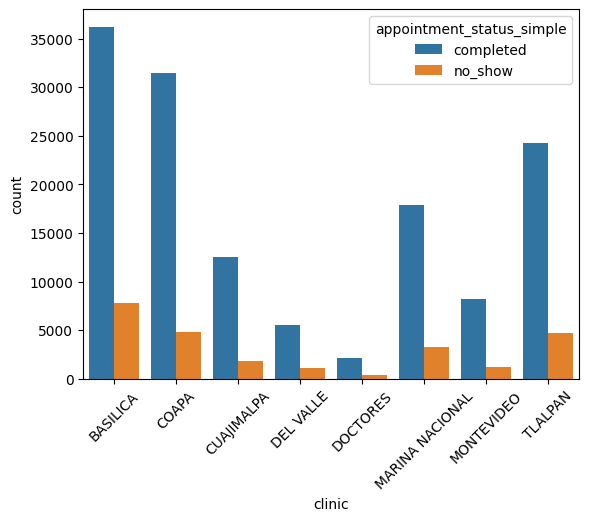

In [154]:
plt = sns.barplot(
    dfy, 
    x="clinic", 
    y="count", 
    hue="appointment_status_simple", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

# Notes

### Duplicated values

In [111]:
dfx.loc[dfx[['appointment_id']].duplicated(keep=False), :].sort_values('appointment_id')

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
123230,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
113004,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
14162,2023000300922,2023-07-31,19:30,20:00,30/07/2023 09:02:21,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
14038,2023000300922,2023-07-31,19:30,20:00,27/07/2023 10:16:46,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
141860,2023000300993,2023-09-18,16:30,17:00,16/09/2023 13:16:36,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,255714,1997-06-27,completed
...,...,...,...,...,...,...,...,...,...,...,...,...
56492,2023138378,2023-12-22,08:30,09:00,21/12/2023 12:01:29,COMPLETADA,DR. Hector Javier Sotelo Reyna,NEUMOLOGIA,BASILICA,282656,1990-03-08,completed
40371,2023144492,2023-12-22,12:00,12:30,17/12/2023 15:27:12,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
40518,2023144492,2023-12-22,12:00,12:30,21/12/2023 11:58:45,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
119738,2023144498,2023-12-22,11:00,11:30,21/12/2023 11:57:58,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,282769,1967-11-18,completed


---

---